In [1]:
!pip install opencv-python==4.5.5.62
!pip install opencv-contrib-python==4.5.5.62
!pip install tf-explain
!pip install keras_applications

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.4 MB 1.8 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.6.0.66
    Uninstalling opencv-python-4.6.0.66:
      Successfully uninstalled opencv-python-4.6.0.66
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 66.6 MB 228 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.6.0.66
    Uninstalling opencv-contrib-python-4.6.0.66:
      Successfully uninstalled opencv-contrib-python-4.6.0.66
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import gc
import sys

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import skimage

In [5]:
from skimage.feature import hog, canny
from skimage.filters import sobel
from skimage import color

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras import layers
import keras.backend as K
from keras.models import Sequential, Model
from keras.preprocessing import image
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import Flatten, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tf_explain.core.grad_cam import GradCAM
from sklearn.model_selection import train_test_split
from keras.utils.data_utils import get_file

from PIL import Image
from tqdm import tqdm
import random as rnd
import cv2
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims

!pip install livelossplot
from livelossplot import PlotLossesKeras
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
BATCH_SIZE = 20
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [7]:
train_main_path = 'drive/MyDrive/input/cattle-disease/train/'
path_train_FMD = train_main_path + 'FMD'
path_train_LSD = train_main_path + 'LSD'
path_train_NOR = train_main_path + 'Normal'

In [8]:
train_df = pd.DataFrame()

In [9]:
classes = []
paths = []

dirs = [path_train_NOR,path_train_FMD, path_train_LSD]
for image_dir in dirs:
    for image in sorted(os.listdir(image_dir)):
          class_ = image_dir.split('/')[3]
          classes.append(class_)
          paths.append(image_dir+'/'+image)

In [10]:
train_df['classname'] = classes
train_df['path'] = paths

# Mục mới

In [11]:
classes = {'Normal': ' Khoe manh','FMD': 'Foot-and-mouth disease', 'LSD': ' lysergic acid diethylamide'}

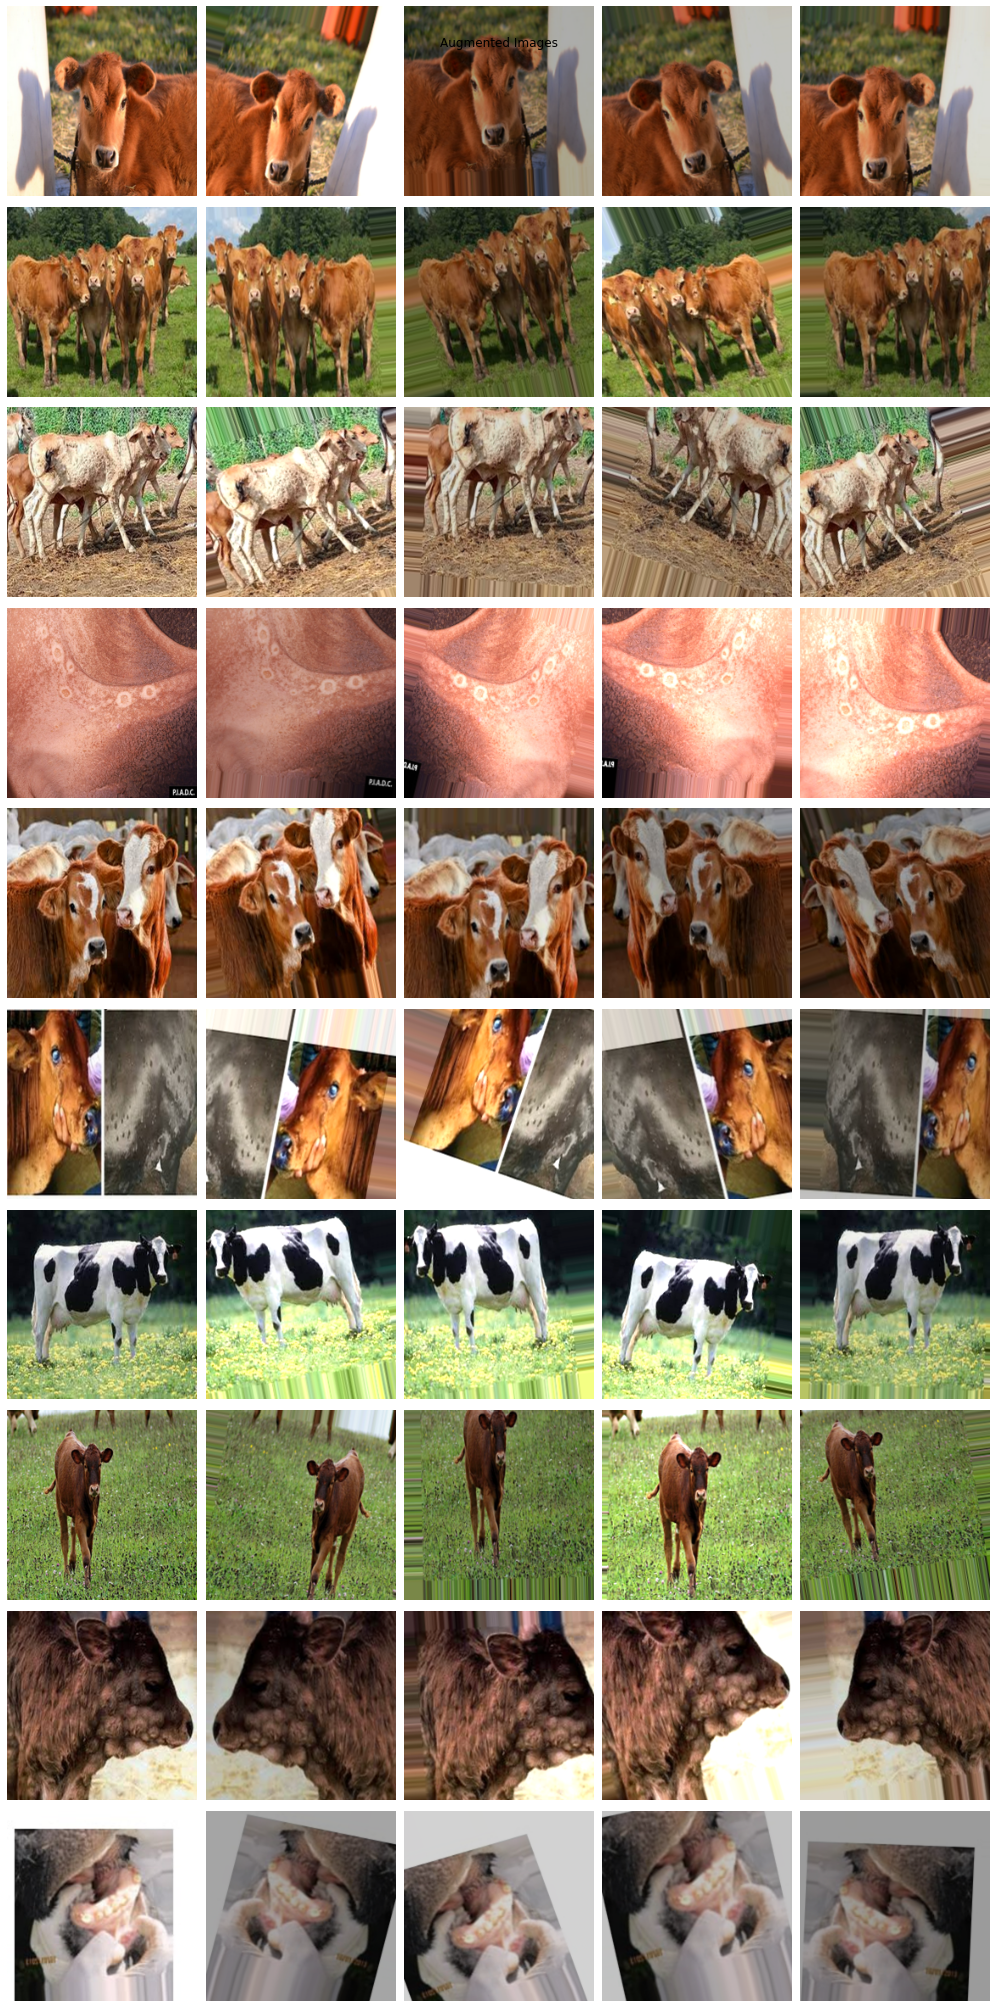

In [12]:
def plot_augimages(paths, datagen):
    plt.figure(figsize = (14,28))
    plt.suptitle('Augmented Images')
    
    midx = 0
    for path in paths:
        data = Image.open(path)
        data = data.resize((224,224))
        samples = expand_dims(data, 0)
        it = datagen.flow(samples, batch_size=1)
    
        # Show Original Image
        plt.subplot(10,5, midx+1)
        plt.imshow(data)
        plt.axis('off')
    
        # Show Augmented Images
        for idx, i in enumerate(range(4)):
            midx += 1
            plt.subplot(10,5, midx+1)
            
            batch = it.next()
            image = batch[0].astype('uint8')
            plt.imshow(image)
            plt.axis('off')
        midx += 1
    
    plt.tight_layout()
    plt.show()

    
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
) 
plot_augimages(np.random.choice(train_df['path'],10), datagen)

In [13]:
val_main_path = 'drive/MyDrive/input/cattle-disease/val'
test_main_path= 'drive/MyDrive/input/cattle-disease/test'

In [14]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
) 
valgen = ImageDataGenerator(rescale=1./255)
testgen = ImageDataGenerator(rescale=1./255)
train_generator_custom_model =datagen.flow_from_directory(
        train_main_path,
        color_mode='rgb',
        target_size=(IMG_WIDTH, IMG_HEIGHT),  # All images will be resized
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=True,
)
val_generator_custom_model = valgen.flow_from_directory(
        val_main_path,
        color_mode='rgb',
        target_size=(IMG_WIDTH, IMG_HEIGHT),  # All images will be resized
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=True,
)

Found 842 images belonging to 3 classes.
Found 75 images belonging to 3 classes.


In [15]:
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)
num_classes = train_generator_custom_model.num_classes

network = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    classes=num_classes,
)

for layer in network.layers:
    layer.trainable = True

83683744/83683744 [==============================] - 5s 0us/step


In [16]:
model = tf.keras.Sequential([
    network,

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=num_classes,
                          activation='softmax',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0005))
])

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
history = model.fit(train_generator_custom_model,
                    epochs=40,
                    validation_data=val_generator_custom_model,
                    verbose=2)

Epoch 1/40
43/43 - 318s - loss: 0.5618 - accuracy: 0.7779 - val_loss: 1.3449 - val_accuracy: 0.7733 - 318s/epoch - 7s/step
Epoch 2/40
43/43 - 20s - loss: 0.3266 - accuracy: 0.8990 - val_loss: 0.6106 - val_accuracy: 0.8933 - 20s/epoch - 465ms/step
Epoch 3/40
43/43 - 20s - loss: 0.3478 - accuracy: 0.9026 - val_loss: 1.6766 - val_accuracy: 0.7200 - 20s/epoch - 473ms/step
Epoch 4/40
43/43 - 20s - loss: 0.2456 - accuracy: 0.9323 - val_loss: 0.7909 - val_accuracy: 0.8533 - 20s/epoch - 475ms/step
Epoch 5/40
43/43 - 20s - loss: 0.1564 - accuracy: 0.9525 - val_loss: 2.2509 - val_accuracy: 0.7733 - 20s/epoch - 469ms/step
Epoch 6/40
43/43 - 20s - loss: 0.1372 - accuracy: 0.9584 - val_loss: 0.6413 - val_accuracy: 0.9067 - 20s/epoch - 469ms/step
Epoch 7/40
43/43 - 21s - loss: 0.0857 - accuracy: 0.9656 - val_loss: 0.2744 - val_accuracy: 0.9333 - 21s/epoch - 498ms/step
Epoch 8/40
43/43 - 20s - loss: 0.0700 - accuracy: 0.9762 - val_loss: 0.3198 - val_accuracy: 0.9467 - 20s/epoch - 467ms/step
Epoch 9/4

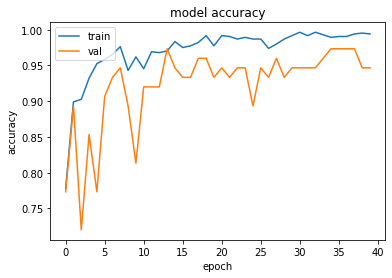

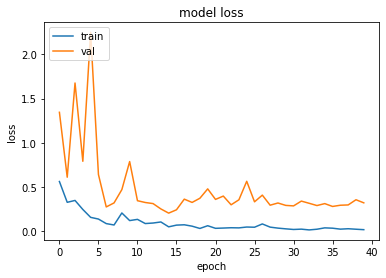

In [19]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
test_data = testgen.flow_from_directory(test_main_path,
                                        shuffle=False,
                                        color_mode="rgb",
                                        class_mode="categorical",
                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                        batch_size=1)

Found 3 images belonging to 3 classes.


In [21]:
from sklearn.metrics import confusion_matrix
import numpy as np

Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)
matrix = confusion_matrix(test_data.classes, y_pred)
     

3/3 [==============================] - 2s 364ms/step


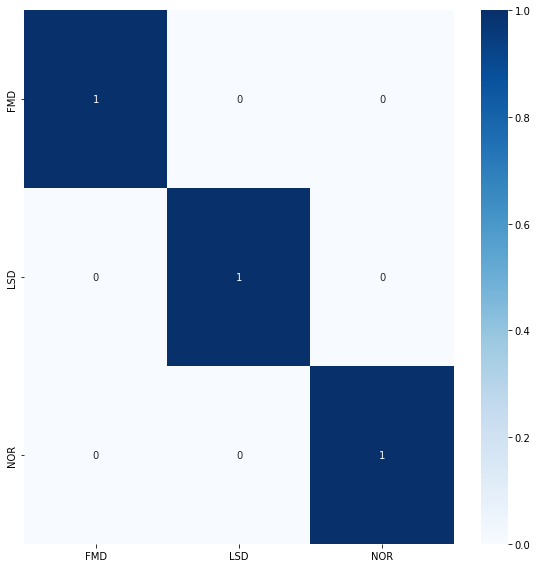

In [22]:

import matplotlib.pyplot as plt 
labels = ['FMD', 'LSD', 'NOR']
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(matrix,
            annot=True,
            cmap=plt.cm.Blues,
            xticklabels=labels,
            yticklabels=labels)
plt.tight_layout()
plt.show()

In [25]:
import shutil
model.save('./custom_model')
shutil.make_archive('custom_model', 'zip', 'custom_model')

import pickle

with open('./custom_hist', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)